<a href="https://colab.research.google.com/github/victorsergio/GNN-trajectory-prediction-2023/blob/main/sac_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jan 19 23:36:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Load clustered dataset
dataframe = pd.read_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_train.csv', sep=',')

In [ ]:
dataframe.describe()

,case_id,track_id,frame_id,timestamp_ms,x,y,vx,vy,psi_rad,length,width,label
count,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000
mean,2634.16096,7.163730,20.000000,2000.000000,1018.105851,1003.645663,1.60804,-0.084499,-0.196957,4.503195,1.733667,0.493801
std,1459.69109,4.006838,11.532572,1153.257167,22.522870,9.534795,4.01982,2.041666,1.517198,0.602154,0.203770,0.646093
min,1.00000,1.000000,1.000000,100.000000,972.187000,964.518000,-15.58800,-14.836000,-3.142000,2.660000,1.350000,0.000000
25%,1356.00000,4.000000,10.500000,1050.000000,998.217000,1000.439000,-0.02200,-0.212000,-1.430000,4.230000,1.560000,0.000000
50%,2728.00000,7.000000,20.000000,2000.000000,1016.885000,1003.893000,0.21000,-0.017000,-0.033000,4.450000,1.650000,0.000000
75%,4006.00000,10.000000,29.500000,2950.000000,1031.413000,1007.871000,2.85800,0.094000,0.098000,4.690000,1.910000,1.000000
max,5163.00000,24.000000,39.000000,3900.000000,1088.321000,1034.248000,17.87600,13.540000,3.142000,12.200000,2.600000,5.000000


In [ ]:
#@title
# Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('scaler', StandardScaler() , ['x','y'])
        ])

dataframe = pd.DataFrame(preprocessor.fit_transform(dataframe), columns= ['x','y','case_id', 'track_id', 'frame_id', 'timestamp_ms', 'agent_type', 
        'vx', 'vy', 'psi_rad', 'length', 'width', 'label'])

# Save scaler to file
import pickle as pkl
with open("/content/drive/MyDrive/PHD_2022/SAC/models/baseline/baseline_train_scaler.pkl", "wb") as outfile:
    pkl.dump(preprocessor, outfile)

In [ ]:
# Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

dataframe_scaled = dataframe[["x", "y", "vx", "vy","psi_rad"]]
dataframe = dataframe.drop(columns=["x", "y", "vx", "vy","psi_rad"], axis=1)

scaler = MinMaxScaler()
dataframe_scaled = pd.DataFrame(scaler.fit_transform(dataframe_scaled), columns=["x", "y", "vx", "vy","psi_rad"])

dataframe = pd.concat([dataframe, dataframe_scaled], axis=1)

# Save scaler to file
import pickle as pkl
with open("/content/drive/MyDrive/PHD_2022/SAC/models/baseline/baseline_train_scaler.pkl", "wb") as outfile:
    pkl.dump(scaler, outfile)


In [ ]:
dataframe.head(5)

,case_id,track_id,frame_id,timestamp_ms,agent_type,length,width,label,x,y,vx,vy,psi_rad
0,1.0,1,1,100,car,4.31,1.48,0,0.291060,0.503471,0.656078,0.514731,0.494271
1,1.0,1,3,300,car,4.31,1.48,0,0.302272,0.502940,0.672902,0.515541,0.495226
2,1.0,1,5,500,car,4.31,1.48,0,0.314447,0.502481,0.689129,0.516387,0.496181
3,1.0,1,7,700,car,4.31,1.48,0,0.327544,0.502065,0.704518,0.517233,0.496817
4,1.0,1,9,900,car,4.31,1.48,0,0.341511,0.501707,0.718832,0.518043,0.497454


In [ ]:
dataframe.describe()

,case_id,track_id,frame_id,timestamp_ms,length,width,label,x,y,vx,vy,psi_rad
count,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000
mean,2634.16096,7.163730,20.000000,2000.000000,4.503195,1.733667,0.493801,0.395395,0.561131,0.513867,0.519858,0.468657
std,1459.69109,4.006838,11.532572,1153.257167,0.602154,0.203770,0.646093,0.193939,0.136739,0.120124,0.071950,0.241438
min,1.00000,1.000000,1.000000,100.000000,2.660000,1.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1356.00000,4.000000,10.500000,1050.000000,4.230000,1.560000,0.000000,0.224138,0.515144,0.465157,0.515365,0.272438
50%,2728.00000,7.000000,20.000000,2000.000000,4.450000,1.650000,0.000000,0.384883,0.564678,0.472089,0.522237,0.494749
75%,4006.00000,10.000000,29.500000,2950.000000,4.690000,1.910000,1.000000,0.509980,0.621727,0.551219,0.526149,0.515595
max,5163.00000,24.000000,39.000000,3900.000000,12.200000,2.600000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
case_id = dataframe.groupby(["case_id", "label"])

scenary_x = []
scenary_y = []



for ix,element in case_id:
    l = element.groupby(["track_id"])
    
    agents = [] # 3 trajectories (scenary), one per agent

    # Get 3 scenary trajectories
    for ig, eg in l:
        feat = eg[["x", "y", "vx", "vy","psi_rad"]]
        f_list = feat.values.tolist()
        agents.append(f_list)
    
    # separate each trajectory


    for tj in agents:
        temp = np.array(tj)
        temp_x = temp[0:10,:]
        temp_y = temp[10:,0:2]  #0:2 only predict x,y

        d_x = np.hstack((temp_x))
        d_x = d_x.reshape(10,1,5) # 5 features

        d_y = np.hstack((temp_y))
        d_y = d_y.reshape(10,1,2) # 2 features

        scenary_x.append(d_x)
        scenary_y.append(d_y)


    #a = np.array(agents[0])
    #b = np.array(agents[1])
    #c = np.array(agents[2])
    #### n cars
    #d = np.array(agents[3])
    #e = np.array(agents[4])
    #f = np.array(agents[5])
    #g = np.array(agents[6])
    #h = np.array(agents[7])
    #i = np.array(agents[8])


    # split
    #a_x = a[0:10,:]
    #a_y = a[10:,:] 

    #b_x = b[0:10,:]
    #b_y = b[10:,:] 
    
    #c_x = c[0:10,:]
    #c_y = c[10:,:] 

    ### n cars
    #d_x = d[0:10,:]
    #d_y = d[10:,:] 

    #e_x = e[0:10,:]
    #e_y = e[10:,:] 
    
    #f_x = f[0:10,:]
    #f_y = f[10:,:]

    #g_x = g[0:10,:]
    #g_y = g[10:,:] 

    #h_x = h[0:10,:]
    #h_y = h[10:,:] 
    
    #i_x = i[0:10,:]
    #i_y = i[10:,:]

    #d_x = np.hstack((a_x))
    #d_x = d_x.reshape(10,1,5) # 5 features

    #d_y = np.hstack((a_y))
    #d_y = d_y.reshape(10,1,5) # 2 features


    #d_x = np.hstack((a_x,b_x,c_x,d_x,e_x,f_x,g_x,h_x,i_x))
    #d_x = d_x.reshape(10,9,5) # 5 features

    #d_y = np.hstack((a_y,b_y,c_y,d_y,e_y,f_y,g_y,h_y,i_y))
    #d_y = d_y.reshape(10,9,5) # 2 features


    #scenary_x.append(d_x)
    #scenary_y.append(d_y)
        
    
s1 = np.array(scenary_x)   
print(s1.shape)

s2 = np.array(scenary_y)   
print(s2.shape)



(31778, 10, 1, 5)
(31778, 10, 1, 2)


In [ ]:
scene_x_train = np.array(scenary_x)
scene_y_train = np.array(scenary_y)

n_samples_train = scene_x_train.shape[0]

# Store interaction groups to use in the future

scene_x_train_interaction = scene_x_train
scene_y_train_interaction = scene_y_train
#scene_x_test_interaction = scene_x_test
#scene_y_test_interaction = scene_y_test


In [ ]:
# split train and test set

from sklearn.model_selection import train_test_split

scene_x_train, scene_x_test, scene_y_train, scene_y_test = train_test_split(scene_x, scene_y, test_size=0.1, random_state=1)


print(scene_x_train.shape)
print(scene_y_train.shape)
print(scene_x_test.shape)
print(scene_y_test.shape)

# Store interaction groups to use in the future

scene_x_train_interaction = scene_x_train
scene_y_train_interaction = scene_y_train
scene_x_test_interaction = scene_x_test
scene_y_test_interaction = scene_y_test

(12265, 10, 1, 5)
(12265, 10, 1, 5)
(1363, 10, 1, 5)
(1363, 10, 1, 5)


In [ ]:
# Split dataset to be used as single agent model predictor
scene_x_train = tf.transpose(scene_x_train, [2, 0, 1, 3])
scene_x_train = tf.reshape(scene_x_train, (n_samples_train * 1, 10, 5))  #batch*nodes, seq_len, feat

#scene_x_test = tf.transpose(scene_x_test, [2, 0, 1, 3])
#scene_x_test = tf.reshape(scene_x_test, (1363 * 1, 10, 5))  #batch*nodes, seq_len, feat

scene_y_train = tf.transpose(scene_y_train, [2, 0, 1, 3])
scene_y_train = tf.reshape(scene_y_train, (n_samples_train * 1, 10, 2))  #batch*nodes, seq_len, feat =  2, only predict x,y

#scene_y_test = tf.transpose(scene_y_test, [2, 0, 1, 3])
#scene_y_test = tf.reshape(scene_y_test, (1363 * 1, 10, 5))  #batch*nodes, seq_len, feat

print(scene_x_train.shape)
print(scene_y_train.shape)
#print(scene_x_test.shape)
#print(scene_y_test.shape)




(31778, 10, 5)
(31778, 10, 2)


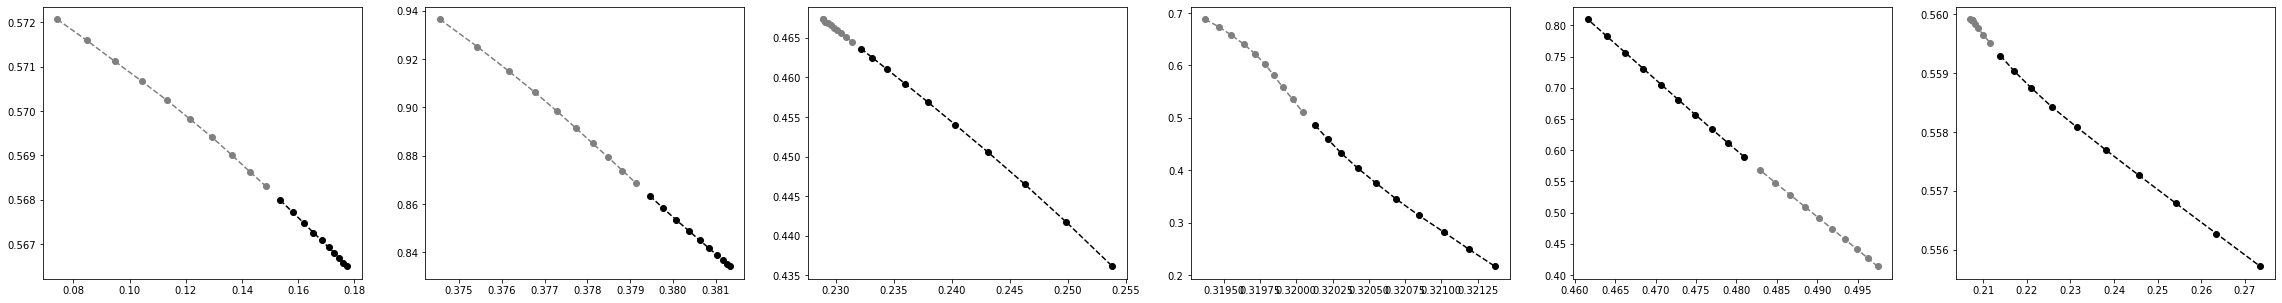

In [ ]:
# Display interaction trajectories

def print_interaction_trajectory(prev_list,ground_list,n,ix):

    fig, ax = plt.subplots(1,n,figsize=(40,5))
    
    prev = prev_list[ix:ix+n]
    ground = ground_list[ix:ix+n]

    

    for j,p in enumerate(prev):
        
        g = ground[j]

        pre = tf.transpose(p,[1,0,2])
        gro = tf.transpose(g,[1,0,2])
     
        color_p = ['gray','cyan','yellow','gray','gray','cyan','yellow','gray','cyan','yellow']
        color_g = ['black','blue','green','black','blue','green','black','blue','green']
 
    
             
        for i,e_p in enumerate(pre):
            e_g = gro[i]

          
            points_p = tf.transpose(e_p,[1,0]) 
            points_g = tf.transpose(e_g,[1,0])

            

            ax[j].plot(points_p[0], points_p[1],'-o', color=color_p[i], linestyle='dashed')
            ax[j].plot(points_g[0], points_g[1],'-o', color=color_g[i], linestyle='dashed')
    
    
    plt.show()

print_interaction_trajectory(scene_x_train_interaction,scene_y_train_interaction,6,20)  # n = number of clusters to show , ix = start index

#print_interaction_trajectory(scene_x_train,scene_y_train,n=6,ix=20)  # n = number of clusters to show , ix = start index



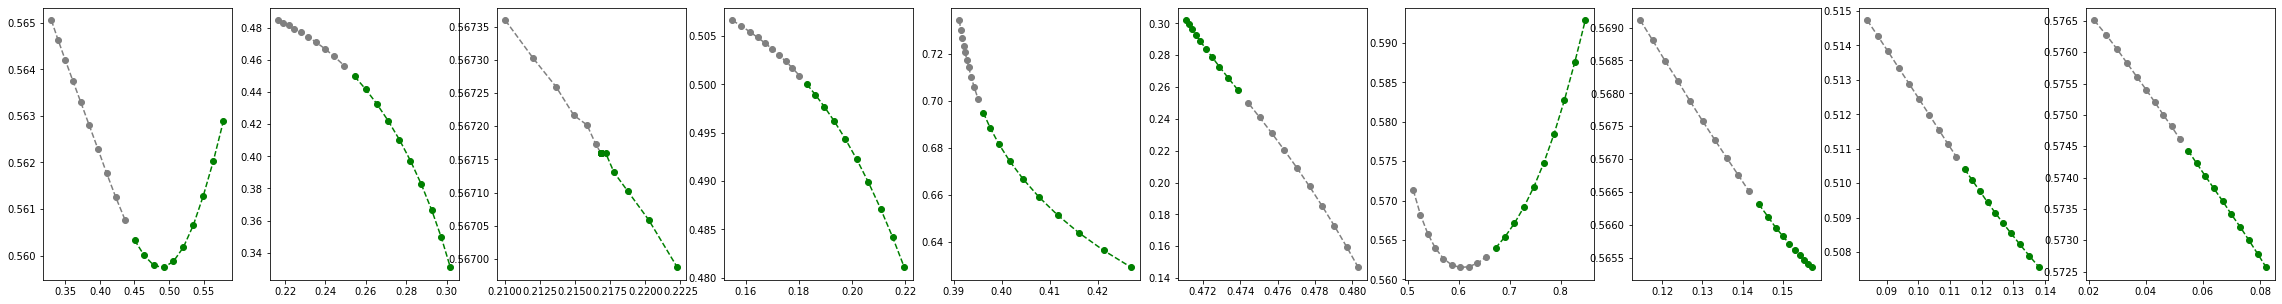

In [ ]:
# Display single trajectories

def print_single_trajectory(prev_list,ground_list,prediction_list,n,ix):
    
    prev = prev_list[ix:ix+n]
    ground = ground_list[ix:ix+n]

    if prediction_list is not None:
        pred = prediction_list[ix:ix+n]
   
    fig, ax = plt.subplots(1,n,figsize=(40,5))


    for i,p in enumerate(prev):
        
        g = ground[i]

        p = tf.transpose(p,[1,0]) 
        g = tf.transpose(g,[1,0])

        ax[i].plot(p[0], p[1],'-o',color='gray',linestyle='dashed')
        ax[i].plot(g[0], g[1],'-o',color='green',linestyle='dashed')

        # if you want to print predictions and ground truths at the same time
        if prediction_list is not None:
            r = pred[i]
            r = tf.transpose(r,[1,0])
            ax[i].plot(r[0], r[1],'-o',color='red',linestyle='dashed')
        
    
    plt.show()

print_single_trajectory(scene_x_train,scene_y_train,None,10,100)

In [ ]:
import tensorflow as tf

input_sequence_length = 10

input_layer = tf.keras.Input(shape=(10,5))

encoder = tf.keras.layers.LSTM(2048, return_sequences=False)(input_layer)
latent_vector = tf.keras.layers.RepeatVector(10)(encoder)
decoder = tf.keras.layers.LSTM(1024, return_sequences=True)(latent_vector)
decoder_last = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=2, activation='relu'))(decoder) # units= 2 because we are only predicting x,y

model = tf.keras.Model(input_layer, decoder_last)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['mse', 'mae']) #0.00003

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 2048)              16826368  
                                                                 
 repeat_vector (RepeatVector  (None, 10, 2048)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 10, 1024)          12587008  
                                                                 
 time_distributed (TimeDistr  (None, 10, 2)            2050      
 ibuted)                                                         
                                                                 
Total params: 29,415,426
Trainable params: 29,415,426
Non-tra

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Load a pre-trained model file
model = tf.keras.models.load_model('/content/drive/My Drive/PHD_2021/GRAPH_INTENTION/data/models/baseline/')

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="baseline-model")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: victorsergio. Use `wandb login --relogin` to force relogin


In [ ]:
#wandb
wandb_callback = WandbCallback(monitor='val_loss', mode='min', log_gradients=False,save_model=False)
# early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0000000000000005, patience=30, mode='min', restore_best_weights=True) #0.00005

# callbacks
callbacks_list = [wandb_callback,early_stopping_callback]

In [ ]:
from sklearn.utils import shuffle
model.fit(
    scene_x_train, scene_y_train, 
    validation_split=0.2,
    batch_size = 128,
    epochs=1000,
    shuffle = True,
    callbacks=callbacks_list,
)

In [ ]:
# saving the model in tensorflow format
model.save('/content/drive/MyDrive/PHD_2022/SAC/models/baseline/')

In [ ]:
# ADE function (single)

import math
def average_displacement_error(pred,ground):

    e = []

    for p,g in zip(pred,ground):
        e.append( math.sqrt (((p[0] - g[0]) ** 2) + ((p[1] - g[1]) ** 2)))

    return np.sum(e)/len(e)


In [ ]:
# ADE function over BATCH (mean)

def calculate_error_batch(results, ground):

    e = [] 

    for r, g in zip(results, ground):
        e.append(average_displacement_error(r,g))
    
    return np.sum(e)/len(e)


In [ ]:
# Evaluate to get MSE error
y_pred = model.evaluate(scene_x_train,scene_y_train)

994/994 [==============================] - 4s 4ms/step - loss: 1.2022e-05 - mse: 1.2022e-05 - mae: 0.0019


In [ ]:
# Predict to get ADE and FDE metrics (Normalized)

results = model.predict(scene_x_train)
#calculate_error_batch(scene_x_train,scene_y_train)

994/994 [==============================] - 3s 3ms/step


In [ ]:
print(results.shape)
print(scene_y_train.shape)

(31778, 10, 2)
(31778, 10, 2)


In [ ]:
calculate_error_batch(results,scene_y_train)

0.0030082280578745857

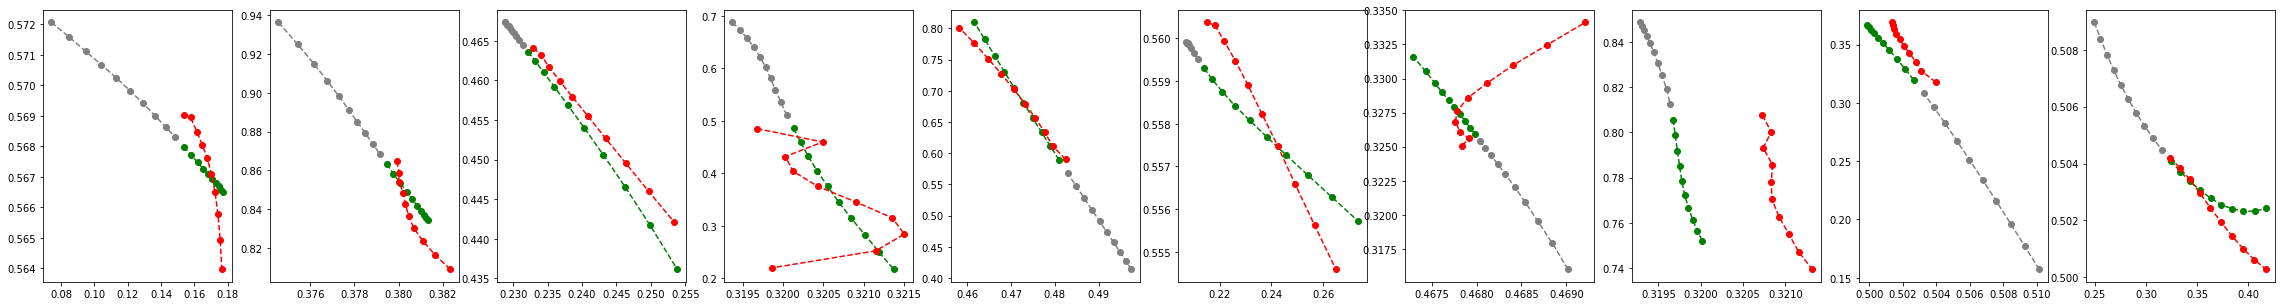

In [ ]:
print_single_trajectory(scene_x_train,scene_y_train, results,10,20)

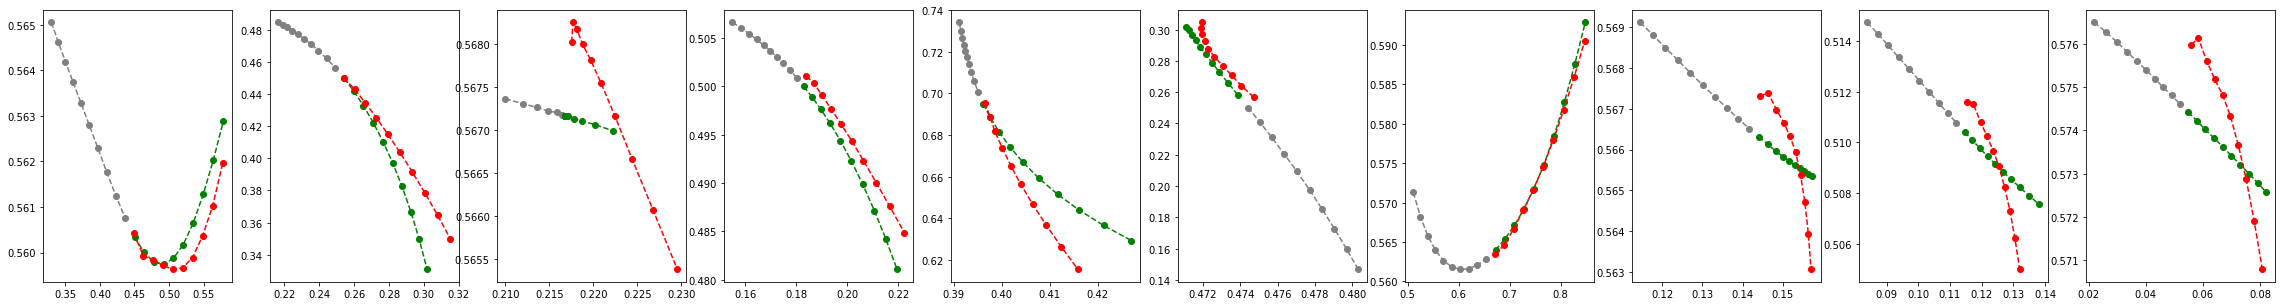

In [ ]:
print_single_trajectory(scene_x_train,scene_y_train, results,10,100)

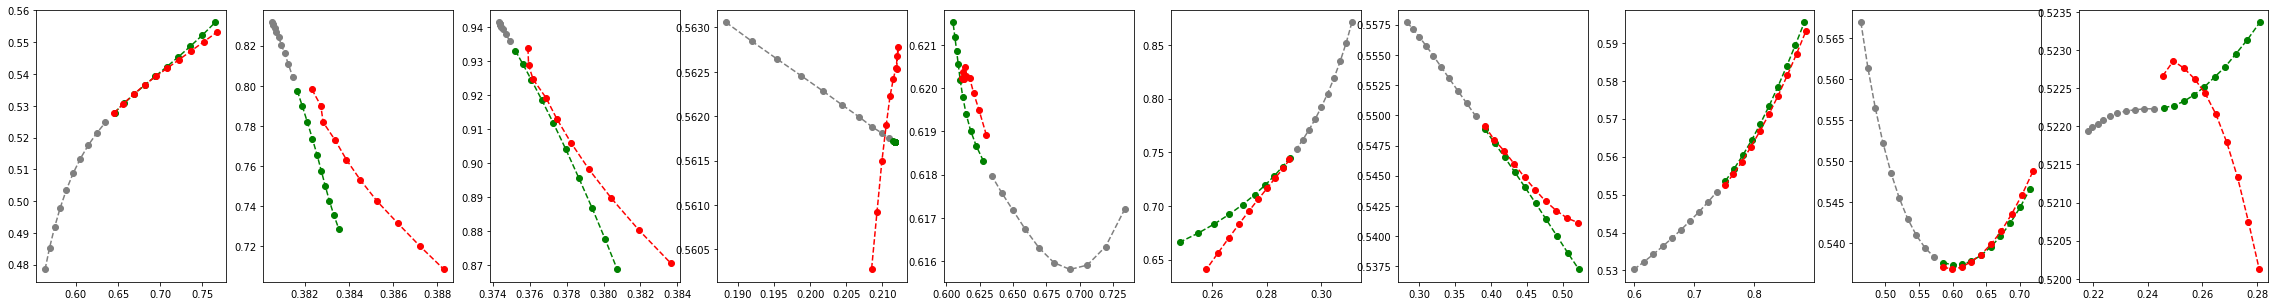

In [ ]:
print_single_trajectory(scene_x_train,scene_y_train, results,10,200)

In [ ]:
results[0]

array([[0.43835902, 0.50176346],
       [0.4563911 , 0.50222903],
       [0.47466275, 0.50322264],
       [0.49311653, 0.50427717],
       [0.5117558 , 0.5054848 ],
       [0.530574  , 0.5068996 ],
       [0.54957515, 0.50862384],
       [0.56871265, 0.5106694 ],
       [0.5879053 , 0.5129845 ],
       [0.60717154, 0.51562923]], dtype=float32)

In [ ]:
scene_x_train.shape

TensorShape([31778, 10, 5])

In [ ]:
results.shape

(317780, 2)

In [ ]:
results = np.reshape(results, (31778*10,2))

In [ ]:
results.shape

(317780, 2)

In [ ]:
df_results = pd.DataFrame(results, columns =['x', 'y']) 

In [ ]:
# add dummy columns, because inverse transform needed the orginal columns used to scale the training set
df_results['vx'] = 0
df_results['vy'] = 0
df_results['psi_rad'] = 0



In [ ]:
df_results.head(5)

,x,y,vx,vy,psi_rad
0,0.438359,0.501763,0,0,0
1,0.456391,0.502229,0,0,0
2,0.474663,0.503223,0,0,0
3,0.493117,0.504277,0,0,0
4,0.511756,0.505485,0,0,0


In [ ]:
#@title
df_results_inv = scaler.inverse_transform(df_results)

In [ ]:
#@title
dataframe_reversed = pd.DataFrame(df_results_inv[:,0:2], columns=["x", "y"])

In [ ]:
#@title
dataframe.describe()

,case_id,track_id,frame_id,timestamp_ms,x,y,vx,vy,psi_rad,length,width,label
count,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000
mean,2634.16096,7.163730,20.000000,2000.000000,1018.105851,1003.645663,1.60804,-0.084499,-0.196957,4.503195,1.733667,0.493801
std,1459.69109,4.006838,11.532572,1153.257167,22.522870,9.534795,4.01982,2.041666,1.517198,0.602154,0.203770,0.646093
min,1.00000,1.000000,1.000000,100.000000,972.187000,964.518000,-15.58800,-14.836000,-3.142000,2.660000,1.350000,0.000000
25%,1356.00000,4.000000,10.500000,1050.000000,998.217000,1000.439000,-0.02200,-0.212000,-1.430000,4.230000,1.560000,0.000000
50%,2728.00000,7.000000,20.000000,2000.000000,1016.885000,1003.893000,0.21000,-0.017000,-0.033000,4.450000,1.650000,0.000000
75%,4006.00000,10.000000,29.500000,2950.000000,1031.413000,1007.871000,2.85800,0.094000,0.098000,4.690000,1.910000,1.000000
max,5163.00000,24.000000,39.000000,3900.000000,1088.321000,1034.248000,17.87600,13.540000,3.142000,12.200000,2.600000,5.000000


In [ ]:
#@title
dataframe_reversed.describe()

,x,y
count,317780.000000,317780.000000
mean,1019.704339,1003.540273
std,22.767534,9.107363
min,972.187000,965.922798
25%,999.220139,1000.437878
50%,1017.341716,1003.896695
75%,1034.383692,1007.737602
max,1088.629796,1034.163628


In [ ]:
#@title
scene_x_train[0]

<tf.Tensor: shape=(10, 5), dtype=float64, numpy=
array([[0.29106033, 0.50347053, 0.65607817, 0.51473076, 0.49427116],
       [0.30227151, 0.50293991, 0.67290222, 0.5155413 , 0.49522597],
       [0.3144471 , 0.502481  , 0.68912862, 0.51638709, 0.49618078],
       [0.32754404, 0.50206511, 0.70451829, 0.51723287, 0.49681731],
       [0.34151067, 0.50170658, 0.71883218, 0.51804342, 0.49745385],
       [0.3562867 , 0.50141976, 0.73189099, 0.51899493, 0.49809039],
       [0.37178604, 0.50120465, 0.74351542, 0.52022836, 0.49872693],
       [0.3879484 , 0.50110426, 0.75364571, 0.52177897, 0.4995226 ],
       [0.40466186, 0.50116162, 0.7623715 , 0.52368198, 0.50031827],
       [0.42186612, 0.50137674, 0.76990198, 0.52583169, 0.50127307]])>

In [ ]:
#@title
df_results_inv.shape

(317780, 5)

In [ ]:
df_results_np = df_results.to_numpy()

In [ ]:
df_results_np.shape

(317780, 5)

In [ ]:
results_reshape = np.reshape(df_results_np, (31778,10,5))

In [ ]:
results_reshape.shape

(31778, 10, 5)

In [ ]:
#@title
scene_x_train.shape

TensorShape([31778, 10, 5])

In [ ]:
elements = []

for ix,e in enumerate(scene_x_train):
    traj = np.append(e.numpy(),results_reshape[ix],axis=0)
    elements.append(traj)

In [ ]:
all_results = np.array(elements)

In [ ]:
all_results.shape

(31778, 20, 5)

In [ ]:
all_results = np.reshape(all_results,(31778*20,5))

In [ ]:
all_results.shape


(635560, 5)

In [ ]:
dataframe_results = pd.DataFrame(all_results[:,0:2], columns=["x", "y"])

In [ ]:
dataframe_results.describe()

,x,y
count,635560.000000,635560.000000
mean,0.395413,0.560948
std,0.193955,0.136758
min,0.000000,0.000000
25%,0.224104,0.515048
50%,0.384924,0.564721
75%,0.510100,0.621294
max,1.002659,1.000000


In [ ]:
dataframe_results.to_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_train_baseline_results.csv',  index = False)

In [ ]:
dataframe.describe()

,case_id,track_id,frame_id,timestamp_ms,x,y,vx,vy,psi_rad,length,width,label
count,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000
mean,2634.16096,7.163730,20.000000,2000.000000,1018.105851,1003.645663,1.60804,-0.084499,-0.196957,4.503195,1.733667,0.493801
std,1459.69109,4.006838,11.532572,1153.257167,22.522870,9.534795,4.01982,2.041666,1.517198,0.602154,0.203770,0.646093
min,1.00000,1.000000,1.000000,100.000000,972.187000,964.518000,-15.58800,-14.836000,-3.142000,2.660000,1.350000,0.000000
25%,1356.00000,4.000000,10.500000,1050.000000,998.217000,1000.439000,-0.02200,-0.212000,-1.430000,4.230000,1.560000,0.000000
50%,2728.00000,7.000000,20.000000,2000.000000,1016.885000,1003.893000,0.21000,-0.017000,-0.033000,4.450000,1.650000,0.000000
75%,4006.00000,10.000000,29.500000,2950.000000,1031.413000,1007.871000,2.85800,0.094000,0.098000,4.690000,1.910000,1.000000
max,5163.00000,24.000000,39.000000,3900.000000,1088.321000,1034.248000,17.87600,13.540000,3.142000,12.200000,2.600000,5.000000


In [ ]:
dataframe_index = dataframe.reset_index(drop=True)
dataframe_results_index = dataframe_results.reset_index(drop=True)

In [ ]:
dataframe_index = dataframe_index.drop(columns=['x', 'y','psi_rad','length','width','vx','vy'])

In [ ]:
dataframe_index.describe()

,case_id,track_id,frame_id,timestamp_ms,label
count,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000
mean,2634.16096,7.163730,20.000000,2000.000000,0.493801
std,1459.69109,4.006838,11.532572,1153.257167,0.646093
min,1.00000,1.000000,1.000000,100.000000,0.000000
25%,1356.00000,4.000000,10.500000,1050.000000,0.000000
50%,2728.00000,7.000000,20.000000,2000.000000,0.000000
75%,4006.00000,10.000000,29.500000,2950.000000,1.000000
max,5163.00000,24.000000,39.000000,3900.000000,5.000000


In [ ]:
dataframe_results_index.describe()

In [ ]:
# add dummy columns, because inverse transform needed the orginal columns used to scale the training set
dataframe_results_index['vx'] = 0
dataframe_results_index['vy'] = 0
dataframe_results_index['psi_rad'] = 0

In [ ]:
dataframe_results_index_inv = scaler.inverse_transform(dataframe_results_index)

In [ ]:
dataframe_reversed = pd.DataFrame(dataframe_results_index_inv[:,0:2], columns=["x", "y"])

In [ ]:
dataframe_reversed.describe()

,x,y
count,635560.000000,635560.000000
mean,1018.107846,1003.632913
std,22.524729,9.536163
min,972.187000,964.518000
25%,998.213072,1000.432289
50%,1016.889734,1003.896000
75%,1031.427000,1007.840840
max,1088.629796,1034.248000


In [ ]:
result_merged = pd.concat([dataframe_index, dataframe_reversed], axis=1,ignore_index=False)

In [ ]:
result_merged.describe()

,case_id,track_id,frame_id,timestamp_ms,label,x,y
count,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000
mean,2634.16096,7.163730,20.000000,2000.000000,0.493801,1018.107846,1003.632913
std,1459.69109,4.006838,11.532572,1153.257167,0.646093,22.524729,9.536163
min,1.00000,1.000000,1.000000,100.000000,0.000000,972.187000,964.518000
25%,1356.00000,4.000000,10.500000,1050.000000,0.000000,998.213072,1000.432289
50%,2728.00000,7.000000,20.000000,2000.000000,0.000000,1016.889734,1003.896000
75%,4006.00000,10.000000,29.500000,2950.000000,1.000000,1031.427000,1007.840840
max,5163.00000,24.000000,39.000000,3900.000000,5.000000,1088.629796,1034.248000


In [ ]:
result_merged.to_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_train_baseline_results.csv',  index = False)

In [ ]:
#@title
# Predict to get ADE and FDE metrics (RAW)


scaler.inverse_transform(scene_x_train)
sca

results = model.predict(scene_x_train)
calculate_error_batch(scene_x_train,scene_y_train)

scaler.inverse_transform(data_scaled)

In [ ]:
#@title
t = np.array([[[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20]],[[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20]]])
u = np.array([[[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20],[10,20]],[[100,200],[100,200],[100,200],[100,200],[100,200],[100,200],[100,200],[100,200],[100,200],[100,200]]])

print(t.shape)
print(u.shape)

(2, 10, 2)
(2, 10, 2)


In [ ]:
#@title
calculate_error_batch(scene_x_train,scene_y_train)

0.19117683071510755

In [ ]:
#@title
calculate_error_batch(scene_x_test,scene_y_test)

0.19054279958229312

In [ ]:
#@title
evaluate_pred = scene_x_test     #original
evaluate_pred_t = tf.transpose(evaluate_pred, [0,2,1, 3])

evaluate_ground = scene_y_test     #original
evaluate_ground_t = tf.transpose(evaluate_ground, [0,2,1, 3])



h = []

for e in evaluate_t:
    h.append(e[0])


print(np.array(h).shape)  



(502, 10, 2)


In [ ]:
#@title
print(results[0])

[[2.242194   0.49625453]
 [2.217759   0.49500656]
 [2.2030003  0.4903936 ]
 [2.190922   0.48204356]
 [2.1840956  0.4743137 ]
 [2.1780179  0.4686251 ]
 [2.1706202  0.46490005]
 [2.1613402  0.4625947 ]
 [2.1504366  0.46119907]
 [2.1384835  0.46036834]]


In [ ]:
#@title
print(results[1])

[[ 0.5972746  -1.4958715 ]
 [ 0.5989837  -1.4937139 ]
 [ 0.5996488  -1.4761806 ]
 [ 0.60216266 -1.4634647 ]
 [ 0.6005164  -1.4450533 ]
 [ 0.5971631  -1.4220117 ]
 [ 0.5931323  -1.396016  ]
 [ 0.58831775 -1.3689764 ]
 [ 0.58223337 -1.3428581 ]
 [ 0.5743798  -1.3190734 ]]


In [ ]:
#@title
r_t = tf.transpose(results, [0,2,1, 3])

In [ ]:
#@title
r_t.shape

TensorShape([502, 3, 8, 2])

In [ ]:
#@title
print(r_t[0])

tf.Tensor(
[[[1013.10706 1004.457  ]
  [1012.0455  1003.8274 ]
  [1013.8372  1004.3048 ]
  [1014.08405 1004.3704 ]
  [1014.1176  1004.3795 ]
  [1014.1221  1004.3807 ]
  [1014.12274 1004.38086]
  [1014.12286 1004.38086]]

 [[1013.10706 1004.457  ]
  [1012.0455  1003.8274 ]
  [1013.8372  1004.3048 ]
  [1014.08405 1004.3704 ]
  [1014.1176  1004.3795 ]
  [1014.1221  1004.3807 ]
  [1014.12274 1004.38086]
  [1014.12286 1004.38086]]

 [[1013.10706 1004.457  ]
  [1012.0455  1003.8274 ]
  [1013.8372  1004.3048 ]
  [1014.08405 1004.3704 ]
  [1014.1176  1004.3795 ]
  [1014.1221  1004.3807 ]
  [1014.12274 1004.38086]
  [1014.12286 1004.38086]]], shape=(3, 8, 2), dtype=float32)


In [ ]:
#@title
import tensorflow as tf
inp = np.empty([3,10,3,2], dtype=int) #(batch_size, input_seq_len, num_nodes, in_feat)

inp = tf.convert_to_tensor(inp, dtype=None, dtype_hint=None, name=None)

print(inp)


tf.Tensor(
[[[[          461040128            11119392]
   [               1430                  -1]
   [                228                   0]]

  [[2314885531812175904 3834870269549490464]
   [3618413830648901686 3760822486181093408]
   [3832622885096272176 2308760229270335544]]

  [[2314885530822320160 3762536702404473905]
   [2319408995090182706 3473455226657185824]
   [3474298634033967665 2314861603925864496]]

  [[3539864629463243552 3474022678039441460]
   [2314911988187674423 3544390292337598496]
   [3978141037057488690 2308669155092870967]]

  [[2314885530822335264 3762536702404473905]
   [2319975252151711026 3473455226657185824]
   [3834587708063691313 2314861603825531192]]

  [[3539864629463243552 4122259549404082228]
   [2314907615843659829 3544390292337598496]
   [3473460797566826290 2314885437353898035]]

  [[3760822486181093467 3976734774637244720]
   [2314885634201038896 3616724976475840544]
   [4050199730573293367 2314861248100775992]]

  [[3539864629463243611 376310

In [ ]:
#@title
inputs = tf.transpose(inp, [2, 0, 1, 3])

print(inputs)

tf.Tensor(
[[[[          461040128            11119392]
   [2314885531812175904 3834870269549490464]
   [2314885530822320160 3762536702404473905]
   [3539864629463243552 3474022678039441460]
   [2314885530822335264 3762536702404473905]
   [3539864629463243552 4122259549404082228]
   [3760822486181093467 3976734774637244720]
   [3539864629463243611 3763101872872828980]
   [3760822486181093467 3617010862485811504]
   [3473455226657185824 4049076038330233393]]

  [[3760822486181093467 4050201942581981488]
   [3473455226657185824 3978701805184365105]
   [3544390292337598496 3546643187738425394]
   [3473455226657185824 3834871382063657521]
   [3544390292337598496 3546643187738425394]
   [3616724976475840544 3832897771458999608]
   [3544390292337598496 4122821387011569714]
   [3616724976475840544 3906928967427569463]
   [4049353098063323168 3907213732416402485]
   [3616724976475840544 3904680457659626040]]

  [[4049353098063323168 3690199828101674037]
   [3834870269549490464 4048791256295814

In [ ]:
#@title
lstminp = tf.reshape(inputs, (3 * 3, 10, 2))
print(lstminp)

tf.Tensor(
[[[          461040128            11119392]
  [2314885531812175904 3834870269549490464]
  [2314885530822320160 3762536702404473905]
  [3539864629463243552 3474022678039441460]
  [2314885530822335264 3762536702404473905]
  [3539864629463243552 4122259549404082228]
  [3760822486181093467 3976734774637244720]
  [3539864629463243611 3763101872872828980]
  [3760822486181093467 3617010862485811504]
  [3473455226657185824 4049076038330233393]]

 [[3760822486181093467 4050201942581981488]
  [3473455226657185824 3978701805184365105]
  [3544390292337598496 3546643187738425394]
  [3473455226657185824 3834871382063657521]
  [3544390292337598496 3546643187738425394]
  [3616724976475840544 3832897771458999608]
  [3544390292337598496 4122821387011569714]
  [3616724976475840544 3906928967427569463]
  [4049353098063323168 3907213732416402485]
  [3616724976475840544 3904680457659626040]]

 [[4049353098063323168 3690199828101674037]
  [3834870269549490464 4048791256295814453]
  [39772955040253

In [ ]:
#@title
  reverse = tf.reshape(lstminp, (3,4, 12,2))
  print(reverse)

In [ ]:
#@title
treverse = tf.transpose(reverse, [1, 2, 0, 3 ])
print(treverse)